<a href="https://colab.research.google.com/github/Amir-D-Shadow/Google-Colab/blob/main/start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
from numba import jit
import random
import os
import pandas as pd
import json
import cv2
import tensorflow.keras.backend as K

In [3]:
def foo(a):

  while True:

    if a > 8:

      break

    a = a + 1

    yield a


In [4]:
for i in foo(3):

  print((i is None))

False
False
False
False
False
False


In [5]:
class CBL(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=2,padding='valid',**kwargs):

      #initialization
      super(CBL,self).__init__(**kwargs)

      #define layers
      self.conv2D_x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      self.output_leaky_relu = tf.keras.layers.LeakyReLU()
      

   def call(self,inputs,train_flag=True):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #convolution layer
      conv2D_x = self.conv2D_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_x,training=train_flag)

      #activate by Leaky relu
      output_leaky_relu = self.output_leaky_relu(BN_x)

      return output_leaky_relu

In [6]:
#activation Mish
def Mish(x):

   softplus = tf.math.softplus(x)
   tanh_s = tf.math.tanh(softplus)

   return (x * tanh_s)


#CBM Module
class CBM(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=2,padding="valid",**kwargs):

      #initialization
      super(CBM,self).__init__(**kwargs)

      #define layers
      self.conv2D_x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      self.output_Mish = tf.keras.layers.Lambda(Mish)

      

   def call(self,inputs,train_flag=True):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #Convolution 2D layer
      conv2D_x = self.conv2D_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_x,training=train_flag)

      #activate by Mish
      output_Mish = self.output_Mish(BN_x)

      return output_Mish

In [7]:
#Backbone CSPX
class CSPX(tf.keras.Model):

   def __init__(self,CSPX_info,**kwargs):

      """
      CSPX_info -- dictionary containing information: num_of_res_unit , res_unit block info , CBM block info , CBL_info

                     - hpara: (filters,kernel_size,strides,padding)

                     
      Module Graph:
      
      ------ CBL_1 ------ CBL_2 ------ res_unit * X ------ CBL_3 -----
                     |                                               |
                     |                                               |______
                     |                                                ______  Concat --- BN --- leaky relu --- CBM_1 
                     |                                               |
                     |                                               |
                     -------------------------------- CBL_4 ----------
      """

      #initialization
      super(CSPX,self).__init__(**kwargs)

      #extract num_of_res_unit
      self.num_of_res_unit = CSPX_info["num_of_res_unit"]

      #define layers

      #res_unit
      self.res_unit_seq = {}

      #Important: When defining the CSPX layer, remember to define res unit info (dictionary key) in the form of res_unit_i : i start from 1
      for i in range(1,self.num_of_res_unit+1):

         #Extract res_unit_i info
         res_unit_info = CSPX_info[f"res_unit_{i}"]

         #define resunit layer
         self.res_unit_seq[f"res_unit_{i}"] = res_unit(res_unit_info)
         

      #CBL_1
      filters,kernel_size,strides,padding = CSPX_info["CBL_1"]
      
      self.CBL_1 = CBL(filters,kernel_size,strides,padding)

      #CBL_2
      filters,kernel_size,strides,padding = CSPX_info["CBL_2"]
      
      self.CBL_2 = CBL(filters,kernel_size,strides,padding)

      #CBL_3
      filters,kernel_size,strides,padding = CSPX_info["CBL_3"]
      
      self.CBL_3 = CBL(filters,kernel_size,strides,padding)

      #CBL_4
      filters,kernel_size,strides,padding = CSPX_info["CBL_4"]
      
      self.CBL_4 = CBL(filters,kernel_size,strides,padding)

      #BN
      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      #leaky relu
      self.leaky_relu_x = tf.keras.layers.LeakyReLU()

      #CBM_1
      filters,kernel_size,strides,padding = CSPX_info["CBM_1"]

      self.CBM_1 = CBM(filters,kernel_size,strides,padding)
      

   def call(self,inputs,train_flag=True):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      x = inputs

      #CBL_1
      CBL_1 = self.CBL_1(x,train_flag)

      #CBL_2
      CBL_2 = self.CBL_2(CBL_1,train_flag)

      #res_unit block
      res_unit_block = CBL_2
      
      for i in range(1,self.num_of_res_unit+1):

         res_unit_block =  (self.res_unit_seq[f"res_unit_{i}"])(res_unit_block,train_flag) 

      #CBL3
      CBL_3 = self.CBL_3(res_unit_block,train_flag)
      
      #CBL_4
      CBL_4 = self.CBL_4(CBL_1,train_flag)

      #Concat
      mid_concat = tf.keras.layers.concatenate(inputs=[CBL_3,CBL_4],axis=-1)

      #Batch Normalization
      BN_x = self.BN_x(mid_concat,training=train_flag)

      #leaky_relu_x
      leaky_relu_x = self.leaky_relu_x(BN_x)

      #output_CBM
      output_CBM = self.CBM_1(leaky_relu_x,train_flag)

      return output_CBM
      



#Neck CSPX
class CSPX_Neck(tf.keras.Model):

   def __init__(self,NECK_info,**kwargs):
      
      """
      NECK_info -- dictionary containing information: num_of_CBL, CBM block info , CBL block info , conv2D info

                     - hpara: (filters,kernel_size,strides,padding)

                     
      Module Graph:
      
      ----------- CBL * X ------ conv2D_1 ----------------
         |                                               |
         |                                               |______
         |                                                ______  Concat --- BN --- leaky relu --- CBM_1 
         |                                               |
         |                                               |
         -------------------------------- conv2D_2 -------
         
      """
      
      #initialization
      super(CSPX_Neck,self).__init__(**kwargs)

      #Get num_of_CBL
      self.num_of_CBL = NECK_info["num_of_CBL"]

      #define layers

      #CBL_X
      self.CBL_seq = {}

      for i in range(1,self.num_of_CBL+1):

         filters,kernel_size,strides,padding = NECK_info[f"CBL_{i}"]

         self.CBL_seq[f"CBL_{i}"] = CBL(filters,kernel_size,strides,padding)


      #Conv2D_1
      filters,kernel_size,strides,padding = NECK_info["conv2D_1"]
      
      self.conv2D_1 = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      #conv2D_2
      filters,kernel_size,strides,padding = NECK_info["conv2D_2"]

      self.conv2D_2 = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      #Batch Normalization
      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)
      
      #leaky relu
      self.leaky_relu_x = tf.keras.layers.LeakyReLU()

      #CBM_1
      filters,kernel_size,strides,padding = NECK_info["CBM_1"]

      self.CBM_1 = CBM(filters,kernel_size,strides,padding)


   def call(self,inputs,train_flag=True):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #CBL_X
      CBL_block = inputs
      
      for i in range(1,self.num_of_CBL+1):

         CBL_block = (self.CBL_seq[f"CBL_{i}"])(CBL_block,train_flag)


      #conv2D_1
      conv2D_1 = self.conv2D_1(CBL_block)

      #conv2D_2
      conv2D_2 = self.conv2D_2(inputs)

      #concat
      mid_concat = tf.keras.layers.concatenate(inputs=[conv2D_1,conv2D_2],axis=-1)

      #BN_x
      BN_x = self.BN_x(mid_concat,training=train_flag)

      #leaky relu
      leaky_relu_x = self.leaky_relu_x(BN_x)

      #CBM_1
      output_CBM = self.CBM_1(leaky_relu_x,train_flag)

      return output_CBM


#revised CSP
class rCSP(tf.keras.Model):


   def __init__(self,rCSP_info,**kwargs):

      """
      rCSP_info -- dictionary containing information:  CBL info 

                     - hpara: (filters,kernel_size,strides,padding)

                     
      Module Graph:
      
                   ------- CBL_2 --- CBL_3 --- CBL_4 --- SPP_1 --- CBL_5 -----
                   |                                                         |
                   |                                                         |______
         CBL_1  ---|                                                          ______  Concat --- CBL_7
                   |                                                         |
                   |                                                         |
                   --------------------------- CBL_6 -------------------------
         
      """
      #initialization
      super(rCSP,self).__init__(**kwargs)

      #CBL_1
      filters,kernel_size,strides,padding = rCSP_info["CBL_1"]
      
      self.CBL_1 = CBL(filters,kernel_size,strides,padding)
      
      #CBL_2
      filters,kernel_size,strides,padding = rCSP_info["CBL_2"]

      self.CBL_2 = CBL(filters,kernel_size,strides,padding)

      #CBL_3
      filters,kernel_size,strides,padding = rCSP_info["CBL_3"]

      self.CBL_3 = CBL(filters,kernel_size,strides,padding)

      #CBL_4
      filters,kernel_size,strides,padding = rCSP_info["CBL_4"]

      self.CBL_4 = CBL(filters,kernel_size,strides,padding)     

      #SPP
      self.SPP_1 = SPP()

      #CBL_5
      filters,kernel_size,strides,padding = rCSP_info["CBL_5"]

      self.CBL_5 = CBL(filters,kernel_size,strides,padding)

      #CBL_6
      filters,kernel_size,strides,padding = rCSP_info["CBL_6"]

      self.CBL_6 = CBL(filters,kernel_size,strides,padding)

      #CBL_7
      filters,kernel_size,strides,padding = rCSP_info["CBL_7"]

      self.CBL_7 = CBL(filters,kernel_size,strides,padding)
      
   def call(self,inputs,train_flag=True):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #CBL_1
      CBL_1 = self.CBL_1(inputs,train_flag)

      #CBL_2
      CBL_2 = self.CBL_2(CBL_1,train_flag)

      #CBL_3
      CBL_3 = self.CBL_3(CBL_2,train_flag)

      #CBL_4
      CBL_4 = self.CBL_4(CBL_3,train_flag)

      #SPP_1
      SPP_1 = self.SPP_1(CBL_4)

      #CBL_5
      CBL_5 = self.CBL_5(SPP_1,train_flag)

      #CBL_6
      CBL_6 = self.CBL_6(CBL_1,train_flag)

      #concat
      mid_concat = tf.keras.layers.concatenate(inputs=[CBL_6,CBL_5],axis=-1)

      #CBL_7
      output_CBL_7 = self.CBL_7(mid_concat,train_flag)

      
      return output_CBL_7



In [8]:
class res_unit(tf.keras.Model):

   def __init__(self,block_info,**kwargs):

      """
      block_info -- dictionary containing blocks' hyperparameters (filters,kernel_size,strides,padding)

      Module Graph:

      ------ CBM_1 ------ CBM_2 ------ Add
         |                              |
         |                              |
         |                              |
         --------------------------------

      
      """

      #initialization
      super(res_unit,self).__init__(**kwargs)
      
      #1st CBM block
      filters,kernel_size,strides,padding = block_info["CBM_1"]
      
      self.CBM_1 = CBM(filters,kernel_size,strides,padding)

      #2nd CBM block
      filters,kernel_size,strides,padding = block_info["CBM_2"]

      self.CBM_2 = CBM(filters,kernel_size,strides,padding)

      #Add Layer
      self.Add_layer = tf.keras.layers.Add()


   def call(self,inputs,train_flag=True):

      x = inputs

      #1st CBM block
      CBM_1 = self.CBM_1(inputs,train_flag)

      #2nd CBM block
      CBM_2 = self.CBM_2(CBM_1,train_flag)

      #Add Layer
      output_shortcut = self.Add_layer([CBM_2,x])

      return output_shortcut


In [9]:
class SPP(tf.keras.Model):

   def __init__(self,**kwargs):

      #initialization
      super(SPP,self).__init__(**kwargs)

      #define layers
      self.maxpool_5x5 = tf.keras.layers.MaxPooling2D(pool_size=5,strides=1,padding="same",data_format="channels_last")

      self.maxpool_9x9 = tf.keras.layers.MaxPooling2D(pool_size=9,strides=1,padding="same",data_format="channels_last")

      self.maxpool_13x13 = tf.keras.layers.MaxPooling2D(pool_size=13,strides=1,padding="same",data_format="channels_last")


   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """
      
      #5x5
      maxpool_5x5 = self.maxpool_5x5(inputs)

      #9x9
      maxpool_9x9 = self.maxpool_9x9(inputs)

      #13x13
      maxpool_13x13 = self.maxpool_13x13(inputs)

      #concatenate
      output_concat = tf.keras.layers.concatenate(inputs=[maxpool_5x5,maxpool_9x9,maxpool_13x13,inputs],axis=-1)

      return output_concat


In [10]:
#TCBL Module
class TCBL(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=1,padding="valid",**kwargs):

      #initialization
      super(TCBL,self).__init__(**kwargs)

      #define layers
      self.conv2D_transpose_x = tf.keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      self.output_leaky_relu = tf.keras.layers.LeakyReLU()

      

   def call(self,inputs,train_flag=True):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #Transpose Convolution 2D layer
      conv2D_transpose_x = self.conv2D_transpose_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_transpose_x,training=train_flag)

      #activate by Mish
      output_leaky_relu = self.output_leaky_relu(BN_x)

      return output_leaky_relu

In [11]:
#TCBM Module
class TCBM(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=2,padding="valid",**kwargs):

      #initialization
      super(TCBM,self).__init__(**kwargs)

      #define layers
      self.conv2D_transpose_x = tf.keras.layers.Conv2DTranspose(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,data_format="channels_last")

      self.BN_x = tf.keras.layers.BatchNormalization(axis=-1)

      self.output_Mish = tf.keras.layers.Lambda(Mish)

      

   def call(self,inputs,train_flag=True):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #Transpose Convolution 2D layer
      conv2D_transpose_x = self.conv2D_transpose_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_transpose_x,training=train_flag)

      #activate by Mish
      output_Mish = self.output_Mish(BN_x)

      return output_Mish

In [12]:
class alpha_model(tf.keras.Model):

   def __init__(self,**kwargs):

      #initialization
      super(alpha_model,self).__init__(**kwargs)

      #CBM_1 in : 640 x 640 x 3 out: 640 x 640 x 32
      filters=32
      kernel_size=3
      strides=1
      padding="same"
      
      self.CBM_1 = CBM(filters,kernel_size,strides,padding)

      #----------------------------------------------------------------

      #CSP1 in : 640 x 640 x 32 out : 319 x 319 x 64
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 1

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (32,1,1,"same")
      res_unit_1["CBM_2"] = (64,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1


      #CBL_1
      CSPX_info["CBL_1"] = (64,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (64,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (64,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (64,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (64,1,1,"same")

      #define CSP1
      self.CSP1 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #CSP2 in : 319 x 319 x 32 out : 159 x 159 x 128
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 2

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (64,1,1,"same")
      res_unit_1["CBM_2"] = (64,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (64,1,1,"same")
      res_unit_2["CBM_2"] = (64,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2


      #CBL_1
      CSPX_info["CBL_1"] = (128,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (64,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (64,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (64,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (128,1,1,"same")

      #define CSP2
      self.CSP2 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #CSP8_1 in : 159 x 159 x 128 out : 79 x 79 x 256
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 8

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (128,1,1,"same")
      res_unit_1["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (128,1,1,"same")
      res_unit_2["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2

      res_unit_3 = {}
      res_unit_3["CBM_1"] = (128,1,1,"same")
      res_unit_3["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_3"] = res_unit_3

      res_unit_4 = {}
      res_unit_4["CBM_1"] = (128,1,1,"same")
      res_unit_4["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_4"] = res_unit_4

      res_unit_5 = {}
      res_unit_5["CBM_1"] = (128,1,1,"same")
      res_unit_5["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_5"] = res_unit_5

      res_unit_6 = {}
      res_unit_6["CBM_1"] = (128,1,1,"same")
      res_unit_6["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_6"] = res_unit_6

      res_unit_7 = {}
      res_unit_7["CBM_1"] = (128,1,1,"same")
      res_unit_7["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_7"] = res_unit_7

      res_unit_8 = {}
      res_unit_8["CBM_1"] = (128,1,1,"same")
      res_unit_8["CBM_2"] = (128,3,1,"same")
      CSPX_info["res_unit_8"] = res_unit_8



      #CBL_1
      CSPX_info["CBL_1"] = (256,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (128,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (128,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (128,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (256,1,1,"same")

      #define CSP8_1
      self.CSP8_1 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #spatialdropout_1 in : 79 x 79 x 256 out : 79 x 79 x 256 , ( branch 1 -- out : 79 x 79 x 256 )
      self.SPA_drop_1 = tf.keras.layers.SpatialDropout2D(rate = 0.5,data_format="channels_last")

      #----------------------------------------------------------------

      #CSP8_2 in : 79 x 79 x 256 out : 39 x 39 x 512
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 8

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (256,1,1,"same")
      res_unit_1["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (256,1,1,"same")
      res_unit_2["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2

      res_unit_3 = {}
      res_unit_3["CBM_1"] = (256,1,1,"same")
      res_unit_3["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_3"] = res_unit_3

      res_unit_4 = {}
      res_unit_4["CBM_1"] = (256,1,1,"same")
      res_unit_4["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_4"] = res_unit_4

      res_unit_5 = {}
      res_unit_5["CBM_1"] = (256,1,1,"same")
      res_unit_5["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_5"] = res_unit_5

      res_unit_6 = {}
      res_unit_6["CBM_1"] = (256,1,1,"same")
      res_unit_6["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_6"] = res_unit_6

      res_unit_7 = {}
      res_unit_7["CBM_1"] = (256,1,1,"same")
      res_unit_7["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_7"] = res_unit_7

      res_unit_8 = {}
      res_unit_8["CBM_1"] = (256,1,1,"same")
      res_unit_8["CBM_2"] = (256,3,1,"same")
      CSPX_info["res_unit_8"] = res_unit_8



      #CBL_1
      CSPX_info["CBL_1"] = (512,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (256,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (256,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (256,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (512,1,1,"same")

      #define CSP8_2
      self.CSP8_2 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #spatialdropout_2 in : 39 x 39 x 512 out : 39 x 39 x 512 , ( branch 2 -- out : 39 x 39 x 512 )
      self.SPA_drop_2 = tf.keras.layers.SpatialDropout2D(rate = 0.5,data_format="channels_last")

      #----------------------------------------------------------------

      #CSP4 in : 39 x 39 x 512 out : 19 x 19 x 1024
      CSPX_info = {}

      #num_of_res_unit
      CSPX_info["num_of_res_unit"] = 4

      #res_unit_info

      res_unit_1 = {}
      res_unit_1["CBM_1"] = (512,1,1,"same")
      res_unit_1["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_1"] = res_unit_1

      res_unit_2 = {}
      res_unit_2["CBM_1"] = (512,1,1,"same")
      res_unit_2["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_2"] = res_unit_2

      res_unit_3 = {}
      res_unit_3["CBM_1"] = (512,1,1,"same")
      res_unit_3["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_3"] = res_unit_3

      res_unit_4 = {}
      res_unit_4["CBM_1"] = (512,1,1,"same")
      res_unit_4["CBM_2"] = (512,3,1,"same")
      CSPX_info["res_unit_4"] = res_unit_4


      #CBL_1
      CSPX_info["CBL_1"] = (1024,3,2,"valid")

      #CBL_2
      CSPX_info["CBL_2"] = (512,1,1,"same")

      #CBL_3
      CSPX_info["CBL_3"] = (512,3,1,"same")

      #CBL_4
      CSPX_info["CBL_4"] = (512,3,1,"same")

      #CBM_1
      CSPX_info["CBM_1"] = (1024,1,1,"same")

      #define CSP4
      self.CSP4 = CSPX(CSPX_info)

      #----------------------------------------------------------------

      #spatialdropout_3 in : 19 x 19 x 1024  out : 19 x 19 x 1024
      self.SPA_drop_3 = tf.keras.layers.SpatialDropout2D(rate = 0.5,data_format="channels_last")

      #----------------------------------------------------------------

      #rCSP1 in : 19 x 19 x 1024 out : 19 x 19 x 512 , ( branch 3 -- out: 19 x 19 x 512 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (1024,3,1,"same")
      rCSP_info["CBL_2"] = (512,1,1,"same")
      rCSP_info["CBL_3"] = (1024,3,1,"same")
      rCSP_info["CBL_4"] = (512,1,1,"same")
      rCSP_info["CBL_5"] = (512,1,1,"same")
      rCSP_info["CBL_6"] = (512,3,1,"same")
      rCSP_info["CBL_7"] = (512,1,1,"same")

      #define rCSP1
      self.rCSP1 = rCSP(rCSP_info)
      #----------------------------------------------------------------

      #CBL_1 in : 19 x 19 x 512 out : 19 x 19 x 256
      self.CBL_1 = CBL(256,1,1,"same")

      #----------------------------------------------------------------

      #bilinear upsampling x4_1 in : 19 x 19 x 256 out : 76 x 76 x 256
      self.upsample_bilinear_x4_1 = tf.keras.layers.UpSampling2D(size=4,interpolation="bilinear",data_format = "channels_last")

      #TCBM_1 in : 76 x 76 x 256 out : 80 x 80 x 256
      self.TCBM_1 = TCBM(256,5,1,"valid")

      #bilinear upsampling x2_1 in : 39 x 39 x 512 out : 78 x 78 x 512 - connect branch 2
      self.upsample_bilinear_x2_1 = tf.keras.layers.UpSampling2D(size=2,interpolation="bilinear",data_format = "channels_last")      

      #TCBM_2 in : 78 x 78 x 512 out : 80 x 80 x 256
      self.TCBM_2 = TCBM(256,3,1,"valid")

      #concat TCBM_1 -- TCBM_2 , out: 80 x 80 x 512

      #----------------------------------------------------------------

      #rCSP2 in : 80 x 80 x 512 out : 39 x 39 x 256 ( branch 4 -- out: 39 x 39 x 256 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (1024,3,2,"valid")
      rCSP_info["CBL_2"] = (512,1,1,"same")
      rCSP_info["CBL_3"] = (1024,3,1,"same")
      rCSP_info["CBL_4"] = (512,1,1,"same")
      rCSP_info["CBL_5"] = (512,1,1,"same")
      rCSP_info["CBL_6"] = (512,3,1,"same")
      rCSP_info["CBL_7"] = (256,1,1,"same")

      #define rCSP2
      self.rCSP2 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #CBL_2 in : 39 x 39 x 256 out : 39 x 39 x 128
      self.CBL_2 = CBL(128,1,1,"same")

      #----------------------------------------------------------------

      #bilinear upsampling x2_2 in : 39 x 39 x 128 out : 78 x 78 x 128
      self.upsample_bilinear_x2_2 = tf.keras.layers.UpSampling2D(size=2,interpolation="bilinear",data_format = "channels_last")

      #TCBM_3 in : 78 x 78 x 128 out : 80 x 80 x 128
      self.TCBM_3 = TCBM(128,3,1,"valid")

      #TCBM_4  in : 79 x 79 x 256 out : 80 x 80 x 128 - connect branch 1 
      self.TCBM_4 = TCBM(128,2,1,"valid")

      #concat TCBM_3 -- TCBM_4 , out: 80 x 80 x 256

      #----------------------------------------------------------------

      #rCSP3 in : 80 x 80 x 256 out : 80 x 80 x 128 ( branch 5 -- out: 80 x 80 x 128 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (256,3,1,"same")
      rCSP_info["CBL_2"] = (128,1,1,"same")
      rCSP_info["CBL_3"] = (256,3,1,"same")
      rCSP_info["CBL_4"] = (128,1,1,"same")
      rCSP_info["CBL_5"] = (128,1,1,"same")
      rCSP_info["CBL_6"] = (128,3,1,"same")
      rCSP_info["CBL_7"] = (128,1,1,"same")

      #define rCSP3
      self.rCSP3 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #decouple head -- small object , in : 80 x 80 x 256  out: 80 x 80 x (1 + 2 + 2 + 80)

      #reg
      self.TCBL_reg_small  = TCBL(256,1,1,"valid")

      self.CBL_left_small = CBL(2,3,1,"same")

      self.CBL_center_small = CBL(2,3,1,"same")

      #class + prob
      self.TCBL_clsp_small  = TCBL(256,1,1,"valid")

      self.CBL_prob_small = CBL(1,3,1,"same")

      self.CBL_class_small = CBL(80,3,1,"same")

      #concat CBL_prob_small -- CBL_left_small -- CBL_center_small -- CBL_class_small  , out: 80 x 80 x 85

      #output small
      self.conv2D_small = tf.keras.layers.Conv2D(85,1,1,padding="same",data_format = "channels_last",name="output_small")

      #----------------------------------------------------------------

      #connect_branch_5_CBL in : 80 x 80 x 128  out: 39 x 39 x 256
      self.connect_branch_5_CBL = CBL(256,3,2,padding="valid")
      
      #concat branch 4 -- branch 5  , out: 39 x 39 x 512

      #----------------------------------------------------------------

      #rCSP4 in : 39 x 39 x 512  out : 39 x 39 x 256 ( branch 6 -- out: 39 x 39 x 256 )
      rCSP_info = {}

      rCSP_info["CBL_1"] = (512,3,1,"same")
      rCSP_info["CBL_2"] = (256,1,1,"same")
      rCSP_info["CBL_3"] = (512,3,1,"same")
      rCSP_info["CBL_4"] = (256,1,1,"same")
      rCSP_info["CBL_5"] = (256,1,1,"same")
      rCSP_info["CBL_6"] = (256,3,1,"same")
      rCSP_info["CBL_7"] = (256,1,1,"same")

      #define rCSP4
      self.rCSP4 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #decouple head -- medium object , in : 39 x 39 x 256  out: 40 x 40 x (1 + 2 + 2 + 80)

      #reg
      self.TCBL_reg_medium  = TCBL(256,2,1,"valid")

      self.CBL_left_medium = CBL(2,3,1,"same")

      self.CBL_center_medium = CBL(2,3,1,"same")

      #class + prob
      self.TCBL_clsp_medium  = TCBL(256,2,1,"valid")

      self.CBL_prob_medium = CBL(1,3,1,"same")

      self.CBL_class_medium = CBL(80,3,1,"same")

      #concat CBL_prob_medium -- CBL_left_medium -- CBL_center_medium -- CBL_class_medium  , out: 40 x 40 x 85
      
      #output medium
      self.conv2D_medium = tf.keras.layers.Conv2D(85,1,1,padding="same",data_format = "channels_last",name="output_medium")

      #----------------------------------------------------------------

      #connect_branch_6_CBL in : 39 x 39 x 256  out: 19 x 19 x 512
      self.connect_branch_6_CBL = CBL(512,3,2,padding="valid")

      #concat branch 3 -- branch 6  , out: 19 x 19 x 1024

      #----------------------------------------------------------------

      #rCSP5 in : 19 x 19 x 1024  out : 19 x 19 x 512 
      rCSP_info = {}

      rCSP_info["CBL_1"] = (1024,3,1,"same")
      rCSP_info["CBL_2"] = (512,1,1,"same")
      rCSP_info["CBL_3"] = (1024,3,1,"same")
      rCSP_info["CBL_4"] = (512,1,1,"same")
      rCSP_info["CBL_5"] = (512,1,1,"same")
      rCSP_info["CBL_6"] = (512,3,1,"same")
      rCSP_info["CBL_7"] = (512,1,1,"same")

      #define rCSP5
      self.rCSP5 = rCSP(rCSP_info)

      #----------------------------------------------------------------

      #decouple head -- large object , in : 19 x 19 x 512   out: 20 x 20 x (1 + 2 + 2 + 80)

      #reg
      self.TCBL_reg_large  = TCBL(512,2,1,"valid")

      self.CBL_left_large = CBL(2,3,1,"same")

      self.CBL_center_large = CBL(2,3,1,"same")

      #class + prob
      self.TCBL_clsp_large  = TCBL(512,2,1,"valid")

      self.CBL_prob_large = CBL(1,3,1,"same")

      self.CBL_class_large = CBL(80,3,1,"same")

      #concat CBL_prob_large -- CBL_left_large -- CBL_center_large -- CBL_class_large  , out: 20 x 20 x 85
      
      #output medium
      self.conv2D_large = tf.keras.layers.Conv2D(85,1,1,padding="same",data_format = "channels_last",name="output_large")

      #----------------------------------------------------------------
      
   def call(self,inputs,train_flag=True):

      #CBM_1
      CBM_1 = self.CBM_1(inputs,train_flag)

      #CSP1
      CSP1 = self.CSP1(CBM_1,train_flag)

      #CSP2
      CSP2 = self.CSP2(CSP1,train_flag)

      #CSP8_1
      CSP8_1 = self.CSP8_1(CSP2,train_flag)

      #spatialdropout_1 -- branch 1
      SPA_drop_1 = self.SPA_drop_1(CSP8_1,training=train_flag)

      #CSP8_2
      CSP8_2 = self.CSP8_2(SPA_drop_1,train_flag)

      #spatialdropout_2 -- branch 2
      SPA_drop_2 = self.SPA_drop_2(CSP8_2,training=train_flag)

      #CSP4
      CSP4 = self.CSP4(SPA_drop_2,train_flag)

      #spatialdropout_3 
      SPA_drop_3 = self.SPA_drop_3(CSP4,training=train_flag)

      #rCSP1 -- branch 3
      rCSP1 = self.rCSP1(SPA_drop_3,train_flag)

      #CBL_1
      CBL_1 = self.CBL_1(rCSP1,train_flag)

      #bilinear upsampling x4_1
      upsample_bilinear_x4_1 = self.upsample_bilinear_x4_1(CBL_1)

      #TCBM_1
      TCBM_1 = self.TCBM_1(upsample_bilinear_x4_1,train_flag)
      
      #bilinear upsampling x2_1 - connect branch 2
      upsample_bilinear_x2_1 = self.upsample_bilinear_x2_1(SPA_drop_2)

      ##TCBM_2 
      TCBM_2 = self.TCBM_2(upsample_bilinear_x2_1,train_flag)

      #mid concat 1 -- concat TCBM_1 -- TCBM_2
      mid_concat_1 = tf.keras.layers.concatenate(inputs=[TCBM_1,TCBM_2],axis=-1)

      #rCSP2 -- branch 4
      rCSP2 = self.rCSP2(mid_concat_1,train_flag)

      #CBL_2
      CBL_2 = self.CBL_2(rCSP2,train_flag)

      #bilinear upsampling x2_2
      upsample_bilinear_x2_2 = self.upsample_bilinear_x2_2(CBL_2)

      #TCBM_3
      TCBM_3 = self.TCBM_3(upsample_bilinear_x2_2,train_flag)

      #TCBM_4 - connect branch 1
      TCBM_4 = self.TCBM_4(SPA_drop_1,train_flag)

      #mid concat 2 -- concat TCBM_3 -- TCBM_4
      mid_concat_2 = tf.keras.layers.concatenate(inputs=[TCBM_3,TCBM_4],axis=-1)

      #rCSP3 -- branch 5
      rCSP3 = self.rCSP3(mid_concat_2,train_flag)

      #decouple head -- small object

      #reg -- small
      TCBL_reg_small = self.TCBL_reg_small(rCSP3,train_flag)

      CBL_left_small = self.CBL_left_small(TCBL_reg_small,train_flag)

      CBL_center_small = self.CBL_center_small(TCBL_reg_small,train_flag)

      #class + prob -- small
      TCBL_clsp_small = self.TCBL_clsp_small(rCSP3,train_flag)

      CBL_prob_small = self.CBL_prob_small(TCBL_clsp_small,train_flag)

      CBL_class_small = self.CBL_class_small(TCBL_clsp_small,train_flag)

      #concat CBL_prob_small -- CBL_left_small -- CBL_center_small -- CBL_class_small  , out: 80 x 80 x 85

      small_concat = tf.keras.layers.concatenate(inputs=[CBL_prob_small,CBL_left_small,CBL_center_small,CBL_class_small],axis=-1)

      #**************** output small ****************
      
      output_small = self.conv2D_small(small_concat)
      
      #**************** output small ****************

      #connect_branch_5_CBL
      connect_branch_5_CBL = self.connect_branch_5_CBL(rCSP3,train_flag)

      #concat branch 4 -- branch 5  , out: 40 x 40 x 512
      mid_concat_br45 = tf.keras.layers.concatenate(inputs=[rCSP2,connect_branch_5_CBL],axis=-1)

      #rCSP4 -- branch 6
      rCSP4 = self.rCSP4(mid_concat_br45,train_flag)

      #decouple head -- medium object

      #reg -- medium
      TCBL_reg_medium = self.TCBL_reg_medium(rCSP4,train_flag)

      CBL_left_medium = self.CBL_left_medium(TCBL_reg_medium,train_flag)

      CBL_center_medium = self.CBL_center_medium(TCBL_reg_medium,train_flag)

      #class + prob -- medium
      TCBL_clsp_medium = self.TCBL_clsp_medium(rCSP4,train_flag)

      CBL_prob_medium = self.CBL_prob_medium(TCBL_clsp_medium,train_flag)

      CBL_class_medium = self.CBL_class_medium(TCBL_clsp_medium,train_flag)

      #concat CBL_prob_medium -- CBL_left_medium -- CBL_center_medium -- CBL_class_medium  , out: 40 x 40 x 85

      medium_concat = tf.keras.layers.concatenate(inputs=[CBL_prob_medium,CBL_left_medium,CBL_center_medium,CBL_class_medium],axis=-1)
      
      #**************** output medium ****************
      
      output_medium = self.conv2D_medium(medium_concat)
      

      #**************** output medium ****************

      #connect_branch_6_CBL
      connect_branch_6_CBL = self.connect_branch_6_CBL(rCSP4,train_flag)

      #concat branch 3 -- branch 6  , out: 19 x 19 x 1024
      mid_concat_br36 = tf.keras.layers.concatenate(inputs=[rCSP1,connect_branch_6_CBL],axis=-1)
      
      #rCSP5
      rCSP5 = self.rCSP5(mid_concat_br36,train_flag)

      #decouple head -- large object 

      #reg -- large
      TCBL_reg_large = self.TCBL_reg_large(rCSP5,train_flag)

      CBL_left_large = self.CBL_left_large(TCBL_reg_large,train_flag)

      CBL_center_large = self.CBL_center_large(TCBL_reg_large,train_flag)

      #class + prob -- large
      TCBL_clsp_large = self.TCBL_clsp_large(rCSP5,train_flag)

      CBL_prob_large = self.CBL_prob_large(TCBL_clsp_large,train_flag)

      CBL_class_large = self.CBL_class_large(TCBL_clsp_large,train_flag)

      #concat CBL_prob_large -- CBL_left_large -- CBL_center_large -- CBL_class_large  , out: 20 x 20 x 85
      large_concat = tf.keras.layers.concatenate(inputs=[CBL_prob_large,CBL_left_large,CBL_center_large,CBL_class_large],axis=-1)
      
      #**************** output large ****************
      
      output_large = self.conv2D_large(large_concat)
      

      #**************** output large ****************

      return [output_large,output_medium,output_small]

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

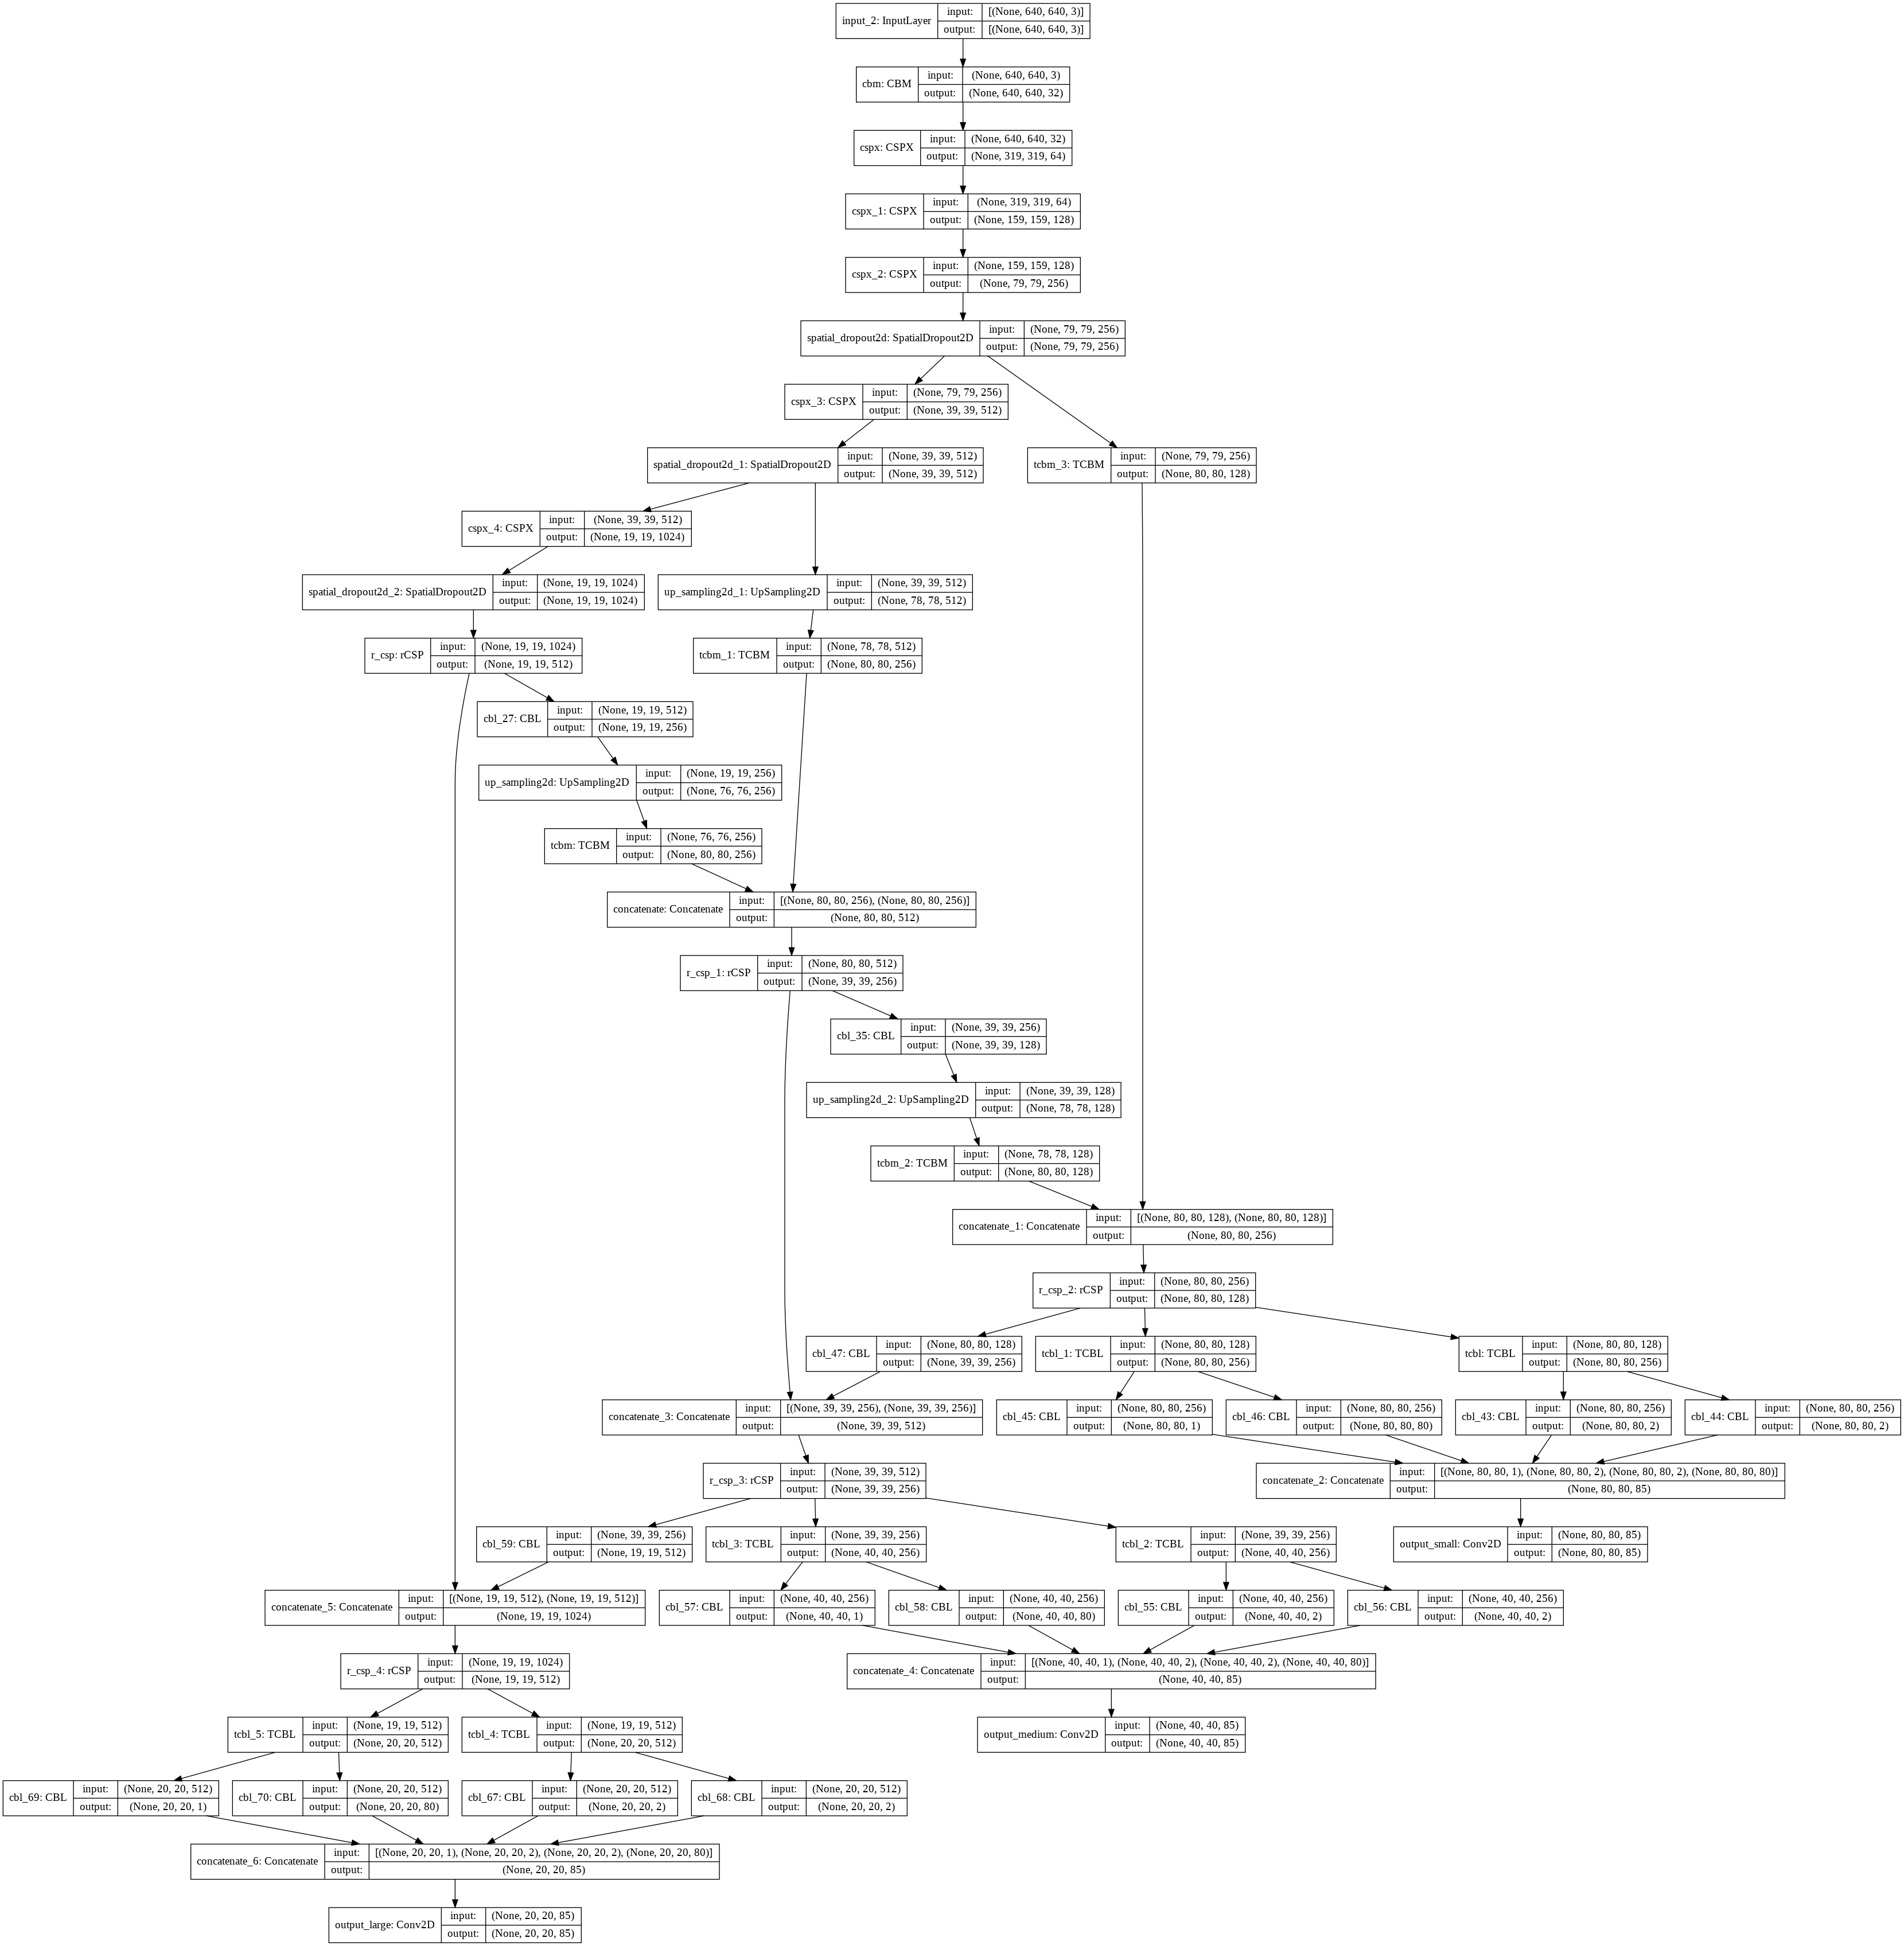

In [13]:
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,640,640,3),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = alpha_model()
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

In [14]:
class alpha_loss(tf.keras.losses.Loss):

  def __init__(self,gamma = 2,**kwargs):

    super(alpha_loss,self).__init__(**kwargs)

    self.gamma = gamma

  def call(self,y_true,y_pred):

    #get prob
    prob_true = y_true[:,:,:,0]
    prob_pred = y_pred[:,:,:,0]

    prob_true = K.cast(prob_true,K.dtype(prob_pred))

    #get class
    class_true = y_true[:,:,:,5:]
    class_pred = y_pred[:,:,:,5:]

    class_true = K.cast(class_true,K.dtype(class_pred))

    #****************** Focal loss ******************

    #get batch size
    m = K.cast(K.shape(y_pred)[0],K.dtype(y_pred))

    #clip the prediction
    prob_pred = K.clip(prob_pred,min_value = 0.0, max_value = 1.0)
    class_pred = K.clip(class_pred,min_value = 0.0, max_value = 1.0)

    #prob focal loss
    loss_tensor =  - ( (1 - prob_pred)**self.gamma ) * prob_true * tf.math.log( prob_pred + 1e-18 ) - ( prob_pred ** self.gamma ) * ( 1 - prob_true ) * tf.math.log( 1 - prob_pred + 1e-18 )
    prob_focal_loss = K.sum(loss_tensor)/ m

    #class focal loss
    loss_tensor =  - ( (1 - class_pred)**self.gamma ) * class_true * tf.math.log( class_pred + 1e-18 ) - ( class_pred ** self.gamma) * ( 1 - class_true ) * tf.math.log( 1 - class_pred + 1e-18 )
    class_focal_loss = K.sum(loss_tensor) / m


    #****************** Focal loss ******************

    #get reg left -- (x,y)
    reg_left_true = y_true[:,:,:,1:3] 
    reg_left_pred = y_pred[:,:,:,1:3]

    reg_left_true = K.cast(reg_left_true,K.dtype(reg_left_pred))

    #get reg center -- (x,y)
    reg_center_true = y_true[:,:,:,3:5] 
    reg_center_pred = y_pred[:,:,:,3:5]

    reg_center_true = K.cast(reg_center_true,K.dtype(reg_center_pred))

    #calculate width x height of anchor box
    reg_wh_true = (reg_center_true[:,:,:,:] - reg_left_true[:,:,:,:])*2
    reg_wh_pred = (reg_center_pred[:,:,:,:] - reg_left_pred[:,:,:,:])*2 

    #calculate reg right
    reg_right_true = reg_left_true[:,:,:,:] + reg_wh_true[:,:,:,:]
    reg_right_pred = reg_left_pred[:,:,:,:] + reg_wh_pred[:,:,:,:]

    #****************** DIOU loss ******************

    #----------------------------------------------------------------------
    #calculate IOU  

    #calculate intersection left
    reg_left_intersection = tf.math.maximum(reg_left_pred,reg_left_true)

    #calculate intersection right
    reg_right_intersection = tf.math.minimum(reg_right_pred,reg_right_true)

    #calibrate
    #reg_right_intersection = tf.where((reg_left_intersection>reg_right_intersection),reg_left_intersection,reg_right_intersection) #-- same meaning
    reg_right_intersection = tf.math.maximum(reg_left_intersection,reg_right_intersection) #-- same meaning

    #intersection width height
    intersection_wh = reg_right_intersection[:,:,:,:] - reg_left_intersection[:,:,:,:]

    #intersection area
    intersection_area = intersection_wh[:,:,:,0] * intersection_wh[:,:,:,1]

    #union area
    true_area = reg_wh_true[:,:,:,0] * reg_wh_true[:,:,:,1]
    pred_area = reg_wh_pred[:,:,:,0] * reg_wh_pred[:,:,:,1]

    union_area = true_area[:,:,:] + pred_area[:,:,:] - intersection_area[:,:,:]

    #calculate iou 
    iou_val = intersection_area[:,:,:] / ( union_area[:,:,:] +  1e-10 )
    #----------------------------------------------------------------------

    #outermost anchor box
    outermost_left = tf.math.minimum(reg_left_pred,reg_left_true)
    outermost_right = tf.math.maximum(reg_right_pred,reg_right_true)

    #outermost distance
    distance_outermost =  K.sum( K.square(outermost_right[:,:,:,:] - outermost_left[:,:,:,:]) ,axis=-1) 
   
    #center distance
    distance_center =  K.sum( K.square(reg_center_true[:,:,:,:] - reg_center_pred[:,:,:,:]) ,axis=-1) 
    #----------------------------------------------------------------------

    #calculate DIOU
    loss_tensor = 1 - (iou_val[:,:,:] - distance_center[:,:,:]/ (distance_outermost[:,:,:] +  1e-10) )
    reg_loss = K.sum(loss_tensor)

    #****************** DIOU loss ******************
 
    #calculate loss
    loss = prob_focal_loss + class_focal_loss + 5 * reg_loss
 
    return loss

In [15]:
def preprocess_class(input_path,save_path ,name="class_map.txt"):

   """
   MS COCO 2017 Dataset

   return dict
   """
   dataset = pd.read_csv(input_path)

   #get class map
   class_array = dataset.iloc[:,3]
   class_map = {}
   idx = 0
   
   for i in range(class_array.shape[0]):

      if not (class_array[i] in class_map.keys()):

         class_map[class_array[i]] = idx
         idx = idx + 1

   #save class map 
   with open(f"{save_path}/{name}","w") as file:
      
     file.write(json.dumps(class_map))

   return class_map

def preprocess_bbox_info(path,path_pos,path_hw,name_pos="bbox_pos.txt",name_hw="bbox_hw.txt"):

   """
   MS COCO 2017 Dataset

   return numpy.ndarray,bbox_pos,bbox_hw
   """

   dataset = pd.read_csv(path)

   """
   #find center
   dataset["center_x"] = (dataset["xmax"] + dataset["xmin"])/2
   dataset["center_y"] = (dataset["ymax"] + dataset["ymin"])/2
   """

   #get positional data
   bbox_pos = dataset.iloc[:,4:].to_numpy()

   #save bbox_pos
   with open(f"{path_pos}/{name_pos}","w") as file:

      file.write(json.dumps(bbox_pos.tolist()))

   #construct bbox_hw (m,2) : h -> 0 , w -> 1
   m = bbox_pos.shape[0]
   bbox_hw = np.zeros((m,2))

   for i in range(m):

      bbox_hw[i,0] = bbox_pos[i,3] - bbox_pos[i,1]
      bbox_hw[i,1] = bbox_pos[i,2] - bbox_pos[i,0]


   #save bbox_hw 
   with open(f"{path_hw}/{name_hw}","w") as file:

      file.write(json.dumps(bbox_hw.tolist()))


   return bbox_pos,bbox_hw


def preprocess_pre_define_anchor_box(bbox_hw,save_path,K=9,name="anchors.txt"):

   """
   bbox_hw -- numpy.ndarray (m,2)
   """

   anchors = Kmean(bbox_hw,K)

   with open(f"{save_path}/{name}","w") as file:

      file.write(json.dumps(anchors.tolist()))

   
   return anchors

def preprocessing_label(input_path,save_path,name="gt_dataset.txt"):

   """
   save dict as {obj1:[[class,xmin,ymin,xcenter,ycenter],[class,xmin,ymin,xcenter,ycenter],...],obj2:...} (for each key)
   """

   #read csv file
   dataset = pd.read_csv(input_path)
   m = dataset.shape[0]

   #calibrate bbox pos
   dataset["xmin"] = dataset["xmin"] + (640 - dataset["width"] )//2
   dataset["xmax"] = dataset["xmax"] + (640 - dataset["width"] )//2

   dataset["ymin"] = dataset["ymin"] + (640 - dataset["height"] )//2
   dataset["ymax"] = dataset["ymax"] + (640 - dataset["height"] )//2

   #calculate center
   dataset["xcenter"] = (dataset["xmin"] + dataset["xmax"])/2
   dataset["ycenter"] = (dataset["ymin"] + dataset["ymax"])/2

   #Group the label
   gt_dataset = {}
   
   for i in range(m):

      filename = dataset.iloc[i,0]
      tmp = []

      #class
      tmp.append(dataset.iloc[i,3])

      #xmin xmax ymin ymax
      tmp.append(dataset.iloc[i,4].item())
      tmp.append(dataset.iloc[i,5].item())
      tmp.append(dataset.iloc[i,8].item())
      tmp.append(dataset.iloc[i,9].item())

      if not ( filename in gt_dataset.keys()  ):

         gt_dataset[filename] = []
         
      gt_dataset[filename].append(tmp)


   #save dataset
   with open(f"{save_path}/{name}","w") as file:

      file.write(json.dumps(gt_dataset))

      file.close()

   return gt_dataset
   
def preprocess_image(img,standard_shape=(640,640)):

   """
   img -- numpy.ndarray
   standard_shape -- (height,width)
   """
   #get h,w
   height,width = standard_shape

   #get pad size
   padH = (height - img.shape[0])//2
   padW = (width - img.shape[1])//2

   #pad img
   diff_H = height - img.shape[0]
   diff_W = width - img.shape[1]
   
   if (diff_H % 2 ) == 0 and (diff_W % 2) == 0:

      img_pad = np.pad(img,((padH,padH),(padW,padW),(0,0)),mode="constant",constant_values=(0,0))

   elif (diff_H % 2 ) != 0 and (diff_W % 2) == 0:

      img_pad = np.pad(img,((padH,padH+1),(padW,padW),(0,0)),mode="constant",constant_values=(0,0))

   elif (diff_H % 2 ) == 0 and (diff_W % 2) != 0:

      img_pad = np.pad(img,((padH,padH),(padW,padW+1),(0,0)),mode="constant",constant_values=(0,0))

   elif (diff_H % 2 ) != 0 and (diff_W % 2) != 0:

      img_pad = np.pad(img,((padH,padH+1),(padW,padW+1),(0,0)),mode="constant",constant_values=(0,0))

   return img_pad
   

def preprocess_y_true(input_path,save_path,anchors,class_map,input_shape = (640,640),pos_info_format = [(76,76,255),(38,38,255),(19,19,255)],bbox_type=3):

   """
   anchors -- numpy.ndarray (K,2)
   input_shape -- (x,y)
   """

   #read csv file
   dataset = pd.read_csv(input_path)
   m = dataset.shape[0]

   #get center info
   dataset["x_center"] = (dataset["xmin"] + dataset["xmax"])/2
   dataset["y_center"] = (dataset["ymin"] + dataset["ymax"])/2

   #calibrate bbox pos
   dataset["xmin"] = dataset["xmin"] + (640 - dataset["width"] )//2
   dataset["xmax"] = dataset["xmax"] + (640 - dataset["width"] )//2

   dataset["ymin"] = dataset["ymin"] + (640 - dataset["height"] )//2
   dataset["ymax"] = dataset["ymax"] + (640 - dataset["height"] )//2

   #set up
   prev_name = "#"
   pos_format_size = len(pos_info_format)

   #loop through dataset
   for i in range(m):

      curr_name = dataset.iloc[i,0]
      class_name = dataset.iloc[i,3]

      if curr_name == prev_name:

         #update pos info
         update_pos_info(pos_info,dataset.iloc[i,8].item(),dataset.iloc[i,9].item(),dataset.iloc[i,4].item(),dataset.iloc[i,5].item(),dataset.iloc[i,6].item(),dataset.iloc[i,7].item(),class_map[dataset.iloc[i,3]],anchors,image_shape=input_shape,bbox_type=bbox_type,feature_size=85)
      
      elif curr_name != prev_name and prev_name != "#":

         #save prev pos info
         for q in range(pos_format_size):
            
            h_size = pos_info_format[q][0]
            w_size = pos_info_format[q][1]
            
            with open(f"{save_path}/{curr_name}_{h_size}x{w_size}.txt","w") as file:

               file.write(json.dumps((pos_info[q]).tolist()))

               file.close()

         #crreate new pos info
         pos_info = [np.zeros(pos_info_format[0]),np.zeros(pos_info_format[1]),np.zeros(pos_info_format[2])]

         #update pos info
         update_pos_info(pos_info,dataset.iloc[i,8].item(),dataset.iloc[i,9].item(),dataset.iloc[i,4].item(),dataset.iloc[i,5].item(),dataset.iloc[i,6].item(),dataset.iloc[i,7].item(),class_map[dataset.iloc[i,3]],anchors,image_shape=input_shape,bbox_type=bbox_type,feature_size=85)

      elif prev_name == "#":

         #crreate new pos info
         pos_info = [np.zeros(pos_info_format[0]),np.zeros(pos_info_format[1]),np.zeros(pos_info_format[2])]

         #update pos info
         update_pos_info(pos_info,dataset.iloc[i,8].item(),dataset.iloc[i,9].item(),dataset.iloc[i,4].item(),dataset.iloc[i,5].item(),dataset.iloc[i,6].item(),dataset.iloc[i,7].item(),class_map[dataset.iloc[i,3]],anchors,image_shape=input_shape,bbox_type=bbox_type,feature_size=85)

      #update prev_name
      prev_name = curr_name

   #save last obj
   for q in range(pos_format_size):
   
      h_size = pos_info_format[q][0]
      w_size = pos_info_format[q][1]
      
      with open(f"{save_path}/{curr_name}_{h_size}x{w_size}.txt","w") as file:

         file.write(json.dumps((pos_info[q]).tolist()))

         file.close()


#@jit(nopython=True)
def update_pos_info(pos_info,center_x,center_y,xmin,ymin,xmax,ymax,class_index,anchors,image_shape = (640,640),bbox_type = 3,feature_size = 85):

   """
   center_info -- (x,y)
   pos_info -- list containing numpy.ndarray
   obj_pos -- numpy.ndarray (1,4)
   anchors -- numpy.ndarray (K,2)
   image_shape -- (x,y)
   """
   
   #object bbox h w
   bbox_h = xmax - xmin
   bbox_w = ymax - ymin
   
   #find bext anchor index
   max_index = 0
   max_iou = 0
   
   for i in range(anchors.shape[0]):

      min_h = np.minimum(anchors[i,0],bbox_h).item()
      min_w = np.minimum(anchors[i,1],bbox_w).item()

      #intersection
      intersection_area = min_w * min_h

      #union
      union_area = bbox_h * bbox_w  + anchors[i,0] * anchors[i,1] - intersection_area

      #iou
      cur_iou = intersection_area / union_area

      if cur_iou > max_iou:

         max_iou = cur_iou

         max_index = i

   #size of particular type
   type_size = np.int64(anchors.shape[0]/bbox_type).item()
   
   #best box index -- dim 1 (determine which type of box)
   best_anchor_index = np.int64(max_index/type_size).item()
      
   #best box index -- dim 2 (in a particular type of box , determine sub class of particular type )
   sub_class_index = max_index % type_size

   #update info (prob,xmin,ymin,xmax,ymax,class)
   #feature mapping
   feature_per_image_pixel_x = pos_info[best_anchor_index].shape[0] / image_shape[0]
   feature_per_image_pixel_y = pos_info[best_anchor_index].shape[1] / image_shape[1]

   target_x = np.int64(center_x * feature_per_image_pixel_x).item()
   target_y = np.int64(center_y * feature_per_image_pixel_y).item()

   #prob
   (pos_info[best_anchor_index])[target_y,target_x,0] = 1

   #xmin,ymin,xmax,ymax
   (pos_info[best_anchor_index])[target_y,target_x,1] = xmin
   (pos_info[best_anchor_index])[target_y,target_x,2] = ymin
   (pos_info[best_anchor_index])[target_y,target_x,3] = xmax
   (pos_info[best_anchor_index])[target_y,target_x,4] = ymax

   #class
   (pos_info[best_anchor_index])[target_y,target_x,(class_index+5)] = 1

In [16]:
#generator
def get_gt_data(batch_size,img_info,class_info,img_path,img_shape = (640,640),standard_scale=(19360,66930)):

   """
   #img_shape -- (height,width)
   """
   
   img_list_shuffled = list(img_info.keys())
   
   random.shuffle(img_list_shuffled)

   m = len(img_list_shuffled)

   idx = 0

   while m >= batch_size:

      """
      #check remaining sample
      #if m < batch_size:

         #break
      """
      
      #get name list
      name_list = []

      for i in range(idx*batch_size,(idx+1)*batch_size):

         name_list.append(img_list_shuffled[i])


      #get image data -- np.array
      img_data = get_image_data(name_list,img_path,img_shape)

      #get y_true data -- tuple (np.array,np.array,np.array)
      label = get_y_true(name_list,img_info,class_info,img_shape,standard_scale)

      #update remaining sample
      m = m - batch_size
      idx = idx + 1

      yield img_data,label

"""
def get_gt_data(batch_size,img_list_shuffled,img_info,class_info,img_path,img_shape = (640,640),standard_scale=(8000,50000)):
   
   random.shuffle(img_list_shuffled)
      
   #get name list
   name_list = []

   for i in range(batch_size):

      name_list.append(img_list_shuffled[i])

      img_list_shuffled.remove(img_list_shuffled[i])


   #get image data -- np.array
   img_data = get_image_data(name_list,img_path,img_shape)

   #get y_true data -- tuple (np.array,np.array,np.array)
   label = get_y_true(name_list,img_info,class_info)

   return img_data,label
"""
      
def get_image_data(name_list,img_path,img_shape=(640,640)):

   """
   return numpy.ndarray
   """

   img_data = []

   for name in name_list:

      #img -- numpy.ndarray
      img = cv2.imread(f"{img_path}/{name}")

      #calibrate image
      img = preprocess_image(img,img_shape)

      #img = cv2.resize(img,(128,128))

      #save img
      img_data.append(img)

   img_data = np.array(img_data)

   return img_data


def get_y_true(name_list,img_info,class_info,img_shape = (640,640),standard_scale=(19360,66930)):

   """
   name_list -- list
   img_info -- dict -- {obj1:[[class,xmin,ymin,xcenter,ycenter],[class,xmin,ymin,xcenter,ycenter],...],obj2:...} (for each key)
   class_info -- dict
   standard_scale -- dict (small , medium , large)
   img_shape -- (height,width)
   """
   #initialize y_true
   small_true = []
   medium_true = []
   large_true = []
   
   
   for name in name_list:


      #initialize y_true extra dim will be removed when it is saved (it is used for overlap region checking)
      obj_small_true = np.zeros((80,80,86))
      obj_medium_true = np.zeros((40,40,86))
      obj_large_true = np.zeros((20,20,86))

      #get (obj_info -- list)
      obj_info = img_info[name]

      #loop via all object in the image (obj -- list)
      for obj in obj_info:

         #update y_true
         obj_small_true,obj_medium_true,obj_large_true = update_y_true(obj,class_info[obj[0]],obj_small_true,obj_medium_true,obj_large_true,img_shape,standard_scale)
         
      #save image info
      small_true.append(obj_small_true[:,:,:-1])
      medium_true.append(obj_medium_true[:,:,:-1])
      large_true.append(obj_large_true[:,:,:-1])

   #convert y_true to numpy array
   small_true = np.array(small_true)
   medium_true = np.array(medium_true)
   large_true = np.array(large_true)

   return (large_true,medium_true,small_true)

   
def update_y_true(obj,class_id,obj_small_true,obj_medium_true,obj_large_true,img_shape = (640,640),standard_scale=(19360,66930)):

   """
   obj -- list [class,xmin,ymin,xcenter,ycenter]
   img_shape -- (height,width)
   """

   _,xmin,ymin,xcenter,ycenter = obj

   width = (xcenter - xmin) * 2
   height = (ycenter - ymin) * 2

   xmax = xmin + width
   ymax = ymin + height

   area  = width * height

   if area < standard_scale[0]:

      step_h = obj_small_true.shape[0] / img_shape[0]
      step_w = obj_small_true.shape[1] / img_shape[1]

      h_pos = int(step_h * ycenter)
      w_pos = int(step_w * xcenter) 
      
      #prob
      obj_small_true[h_pos,w_pos,0] = 1

      #xmin,ymin
      obj_small_true[h_pos,w_pos,1] = xmin
      obj_small_true[h_pos,w_pos,2] = ymin

      #xcenter,ycenter
      obj_small_true[h_pos,w_pos,3] = xcenter
      obj_small_true[h_pos,w_pos,4] = ycenter

      #class
      obj_small_true[h_pos,w_pos,5+class_id] = 1

      #label occupied cells
      obj_small_true[h_pos,w_pos,-1] == 1

      #multiple positive
      obj_small_true = multiple_positive_labeling(obj_small_true,class_id,xmin,ymin,xmax,ymax,xcenter,ycenter,step_w,step_h)

   elif (area > standard_scale[0]) and (area < standard_scale[1]):

      step_h = obj_medium_true.shape[0] / img_shape[0]
      step_w = obj_medium_true.shape[1] / img_shape[1]

      h_pos = int(step_h * ycenter)
      w_pos = int(step_w * xcenter) 
      
      #prob
      obj_medium_true[h_pos,w_pos,0] = 1

      #xmin,ymin
      obj_medium_true[h_pos,w_pos,1] = xmin
      obj_medium_true[h_pos,w_pos,2] = ymin

      #xcenter,ycenter
      obj_medium_true[h_pos,w_pos,3] = xcenter
      obj_medium_true[h_pos,w_pos,4] = ycenter

      #class
      obj_medium_true[h_pos,w_pos,5+class_id] = 1

      #label occupied cells
      obj_medium_true[h_pos,w_pos,-1] == 1

      #multiple positive
      obj_medium_true = multiple_positive_labeling(obj_medium_true,class_id,xmin,ymin,xmax,ymax,xcenter,ycenter,step_w,step_h)

   elif (area > standard_scale[1]) :

      step_h = obj_large_true.shape[0] / img_shape[0]
      step_w = obj_large_true.shape[1] / img_shape[1]

      h_pos = int(step_h * ycenter)
      w_pos = int(step_w * xcenter) 
      
      #prob
      obj_large_true[h_pos,w_pos,0] = 1

      #xmin,ymin
      obj_large_true[h_pos,w_pos,1] = xmin
      obj_large_true[h_pos,w_pos,2] = ymin

      #xcenter,ycenter
      obj_large_true[h_pos,w_pos,3] = xcenter
      obj_large_true[h_pos,w_pos,4] = ycenter

      #class
      obj_large_true[h_pos,w_pos,5+class_id] = 1

      #label occupied cells
      obj_large_true[h_pos,w_pos,-1] == 1

      #multiple positive
      obj_large_true = multiple_positive_labeling(obj_large_true,class_id,xmin,ymin,xmax,ymax,xcenter,ycenter,step_w,step_h)

   return obj_small_true,obj_medium_true,obj_large_true

            
@jit(nopython=True)  
def multiple_positive_labeling(y_true,class_id,xmin,ymin,xmax,ymax,xcenter,ycenter,step_w,step_h):

   """
   y_true -- numpy array
   """

   w_pos_init = int(xmin*step_w)
   h_pos_init = int(ymin*step_h)

   w_max = int(xmax*step_w)
   h_max = int(ymax*step_h)

   for w_pos in range(w_pos_init,w_max):

      for h_pos in range(h_pos_init,h_max):

         if y_true[h_pos,w_pos,-1] == 0:

            #prob
            y_true[h_pos,w_pos,0] = 1

            #xmin,ymin
            y_true[h_pos,w_pos,1] = xmin
            y_true[h_pos,w_pos,2] = ymin

            #xcenter,ycenter
            y_true[h_pos,w_pos,3] = xcenter
            y_true[h_pos,w_pos,4] = ycenter

            #class
            y_true[h_pos,w_pos,5+class_id] = 1

            #label occupied cells
            y_true[h_pos,w_pos,-1] == 1


   return y_true 



In [ ]:
#step function
@tf.function
def distributed_train_step(data_inputs):

   per_replica_losses = strategy.run(train_step,args=(data_inputs,))

   return strategy.reduce(tf.distribute.ReduceOp.SUM,per_replica_losses,axis=None)


def train_step(inputs):

   images,labels = inputs

   with tf.GradientTape() as tape:

      predictions = model(images,train_flag=True)
      
      loss = compute_loss(labels,predictions)

   gradients = tape.gradient(loss,model.trainable_weights)

   optimizer.apply_gradients(zip(gradients,model.trainable_weights))

   return loss

#find current path
cur_path = os.getcwd()

#define strategy
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

#define model,loss,optimizer
with strategy.scope():

   #define loss object
   loss_object = alpha_loss(reduction=tf.keras.losses.Reduction.NONE)

   #define compute loss
   def compute_loss(labels,predictions):

      #large
      large_obj_loss = loss_object(labels[0],predictions[0])

      #medium
      medium_obj_loss = loss_object(labels[1],predictions[1])

      #small
      small_obj_loss = loss_object(labels[2],predictions[2])

      #total loss
      total_loss = large_obj_loss + medium_obj_loss + small_obj_loss

      return total_loss 

   #define optimizer
   optimizer = tf.keras.optimizers.Adam()

   #define model
   #model = alpha_model()
   model = tf.keras.models.load_model(f"{cur_path}/gdrive/MyDrive/model")
   

batch_size_per_replica = 4

EPOCHS = 100

#preprocessing class
input_path = f"{cur_path}/gdrive/MyDrive/annotations/train_annotations.csv"
save_path = f"{cur_path}/gdrive/MyDrive/data"

class_train_info = preprocess_class(input_path,save_path)

#preprocessing label
input_path = f"{cur_path}/gdrive/MyDrive/annotations/test_annotations.csv"
save_path = f"{cur_path}/gdrive/MyDrive/data"

img_train_info = preprocessing_label(input_path,save_path)

#train image path
img_train_path = f"{cur_path}/gdrive/MyDrive/img"

img_shape = (640,640)
standard_scale=(19360,66930)

#get number of sample m
m = len(list(img_train_info.keys()))

#dataset size
global_batch_size = batch_size_per_replica * strategy.num_replicas_in_sync
buffer_size = global_batch_size * 2

#total step per epochs
total_step_per_epoch = int(m/buffer_size)


#train
for i  in range(EPOCHS):

   total_loss = 0.0

   #get data 
   for train_images, train_labels in get_gt_data(buffer_size,img_train_info,class_train_info,img_train_path,img_shape,standard_scale):

      #normalize the image to 0 to 1
      train_images = train_images/ np.float64(255)

      # Create Datasets from the batches
      train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size).batch(global_batch_size)

      #create distributed dataset
      train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

      #Do training
      for batch in train_dist_dataset:

         total_loss = total_loss + distributed_train_step(batch) 
   
   total_loss = total_loss 
   
   print(f"Epoch {i+1} , Loss: {total_loss}")

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [ ]:
tf.keras.models.save_model(model,f"{cur_path}/gdrive/MyDrive/model")